In [1]:
import scipy.stats as st
import numpy as np
import scipy as sp
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
class DatasetGenerator(object):
    def __init__(self, N=100):
        self.N = N
        self.x = None
        self.v = None
        self.refresh()

    def refresh(self):
        raise Exception("undefined")

class G1(DatasetGenerator):
    def refresh(self):
        self.x = st.uniform().rvs((self.N,2))
        self.v = st.uniform().rvs((self.N,))

class G2(DatasetGenerator):
    def refresh(self):
        self.x = st.uniform().rvs((self.N,2))
        self.v = np.exp(st.norm(-0.85, 1.3).rvs((self.N,)))

## Choosing $\beta$

#### Explanation of the method

In the lecture notes, it is suggested to use the following formula to choose the value of $\beta$:
$$
\beta = \frac{1}{f_1 - f_0} \log \left(\frac{N_1}{N_0 \cdot \epsilon}\right)
$$
with: 
- $\epsilon$, the fraction of time we desire to spend in global minima
- $f_0$, the global minimum of the function $f$
- $f_1$, the second global minimum of the function $f$
- $N_0$, the number of states where $ f = f_0 $
- $N_1$, the number of states where $ f = f_1 $

We propose the following algorithm to estimate these quantities:
- Generate a random dataset $\mathcal{G}$
- Repeat the following 1000 times:
>- Pick randomly 2 cities, define the segment connecting them as the diameter of the circle containing the cities to include $\mathcal{S}$
>- Compute $f(\lambda, \mathcal{S})$ and store it
- At this stage, we have a distribution of 1000 random evaluations of $f$
- Define $f_0$ as the minimum value of these evaluations
- Define $f_1$ as the second minimum value of these evaluations
- $N_0$ is the number of instances equal to $f_0$
- $N_1$ is the number of instances equal to $f_1$
- Compute $\beta$ for the desired value of $\epsilon$

In [3]:
class BetaOptimizer():
    def __init__(self, generator_class, lambda_, N, n_iterations, verbose=False):
        self.N = N
        self.g = generator_class(N)
        self.lambda_ = lambda_
        self.n_iterations = n_iterations
        self.distances_matrix = sp.spatial.distance_matrix(self.g.x, self.g.x)
        self.verbose = verbose

        # variables recording results
        self.f_vec = []

    def __str__(self):
        s = f"generator: {self.g}\n" +\
            f"lambda: {self.lambda_}\n" +\
            f"N: {self.N}\n" +\
            f"n_iterations: {self.n_iterations}"
        return s

    def compute_max_distance(self, included_ids):
        max_distance = self.distances_matrix[np.ix_(included_ids, included_ids)].max()
        return max_distance
            
    def compute_f(self, max_distance, population):
        circular_area = np.pi * (max_distance / 2)**2
        return self.lambda_ * self.N * circular_area - population

    def run(self):
        for i in range(self.n_iterations):
            # Generate circle with random radius and circle in the [0, 1]^2 square
            extreme_ids = np.random.choice(N, size=2)
            max_distance = np.linalg.norm(self.g.x[extreme_ids[0]] 
                                          - self.g.x[extreme_ids[1]])
            radius = max_distance / 2
            center = self.g.x[extreme_ids, :].mean(axis=0)
            
            # identify nodes inside the circle
            included_ids = np.where(sp.spatial.distance.cdist(center.reshape(1, -1), self.g.x) < radius)[1]
            population = self.g.v[included_ids].sum()
            f_val = self.compute_f(max_distance, population)

            self.f_vec.append(f_val.copy())

### Generative model $G_1$

In [4]:
generator_class = G1
N = 1000
n_iterations = 1000
lambda_vec = np.linspace(0, 1, 10)

Let's first look at the distribution of the values of $f$ in the case $\lambda = 0$:

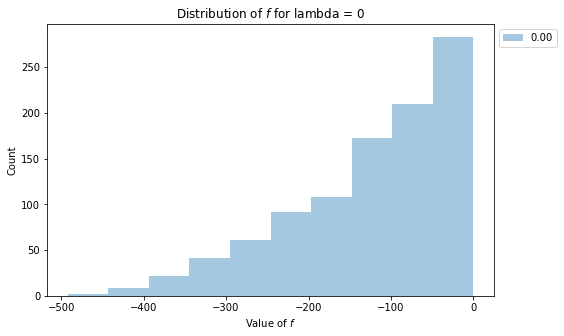

In [5]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.set_title(f"Distribution of $f$ for lambda = 0")
for lambda_ in [0.]:
    bo = BetaOptimizer(generator_class, lambda_, N, n_iterations, verbose=False)
    bo.run()
    ax.hist(bo.f_vec, label=f"{bo.lambda_:.2f}", alpha=0.4)
ax.set_xlabel('Value of $f$')
ax.set_ylabel('Count')
ax.legend(bbox_to_anchor=(1,1))

Now let's look at the distribution of the values of $f$ for several values of $\lambda$:

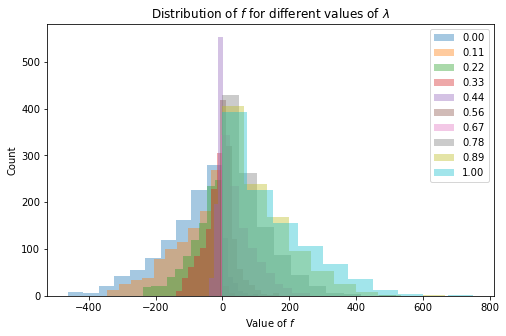

In [6]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.set_title(r"Distribution of $f$ for different values of $\lambda$")
for lambda_ in lambda_vec:
    bo = BetaOptimizer(generator_class, lambda_, N, n_iterations, verbose=False)
    bo.run()
    ax.hist(bo.f_vec, label=f"{bo.lambda_:.2f}", alpha=0.4)
ax.set_xlabel('Value of $f$')
ax.set_ylabel('Count')
ax.legend(bbox_to_anchor=(1,1))

#### We define the function to compute $\beta$ from the distribution as `compute_beta_vec`

In [7]:
def compute_beta_vec(bo, epsilon_vec):
    """Compute beta from distribution of f."""
    sorted_f_vec = np.sort(bo.f_vec)
    f0 = sorted_f_vec[0]
    N0 = ((sorted_f_vec - f0) == 0).sum()
    f1_index = np.where((sorted_f_vec - f0) > 0)[0][0]
    f1 = sorted_f_vec[f1_index]
    N1 = ((sorted_f_vec - f1) == 0).sum()
    beta_vec = np.log(N1 / (N0 * epsilon_vec)) / (f1 - f0)
    return beta_vec

We now compute $\beta$ for different values of $\epsilon$ and for different values of $\lambda$.
We compute 50 iterations for each fixed values of $\epsilon$ and $\lambda$ in order to have a robust estimate of $\beta$ by taking the average of these 50 iterations.

In [8]:
generator_class = G1
n_iterations = 1000
n_beta_iterations = 50
beta_vec_list = []
epsilon_vec = np.linspace(0.05, 0.95, 10)
lambda_arrays_list = []
for lambda_ in lambda_vec:
    print(f"Compute for lambda = {lambda_}")
    for i in range(n_beta_iterations):
        bo = BetaOptimizer(generator_class, lambda_, N, n_iterations, verbose=False)
        bo.run()
        beta_vec = compute_beta_vec(bo, epsilon_vec)
        beta_vec_list.append(beta_vec)
    lambda_arrays_list.append(np.array(beta_vec_list))

Compute for lambda = 0.0
Compute for lambda = 0.1111111111111111
Compute for lambda = 0.2222222222222222
Compute for lambda = 0.3333333333333333
Compute for lambda = 0.4444444444444444
Compute for lambda = 0.5555555555555556
Compute for lambda = 0.6666666666666666
Compute for lambda = 0.7777777777777777
Compute for lambda = 0.8888888888888888
Compute for lambda = 1.0


We plot the 50 iterations for $\lambda = 0$. Note that the average of all the iterations is shown in red:

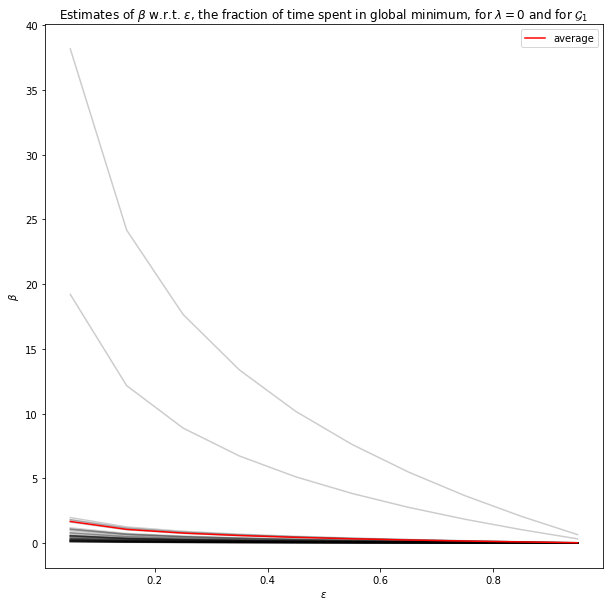

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title(r"Estimates of $\beta$ w.r.t. $\epsilon$, the fraction of time spent in global minimum, for $\lambda = 0$ and for $\mathcal{G}_1$")
beta_array = lambda_arrays_list[0] # select the one corresponding to lambda = 0
for i in range(len(beta_array)):
    ax.plot(epsilon_vec, beta_array[i, :], color='k', alpha=0.2)
ax.plot(epsilon_vec, beta_array.mean(0), color='r', label='average')
ax.set_xlabel(r'$\epsilon$')
ax.set_ylabel(r'$\beta$')
plt.legend()

Now we show only the averages for each value of $\lambda$:

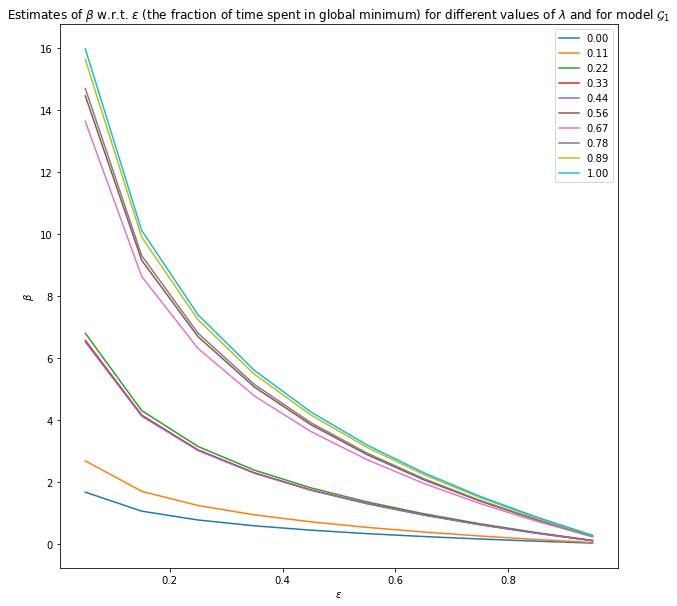

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title(r"Estimates of $\beta$ w.r.t. $\epsilon$ (the fraction of time spent in global minimum) "\
             r"for different values of $\lambda$ and for model $\mathcal{G}_1$")
for i, lambda_array in enumerate(lambda_arrays_list):
    ax.plot(epsilon_vec, lambda_array.mean(0), label=f"{lambda_vec[i]:.2f}")
ax.set_xlabel(r'$\epsilon$')
ax.set_ylabel(r'$\beta$')
plt.legend()

The values of $\beta$ corresponding to the smallest value of $\epsilon$, i.e. $\epsilon = 0.05$ are:

In [11]:
initials_beta = [lambda_array[:, 0].mean() for lambda_array in lambda_arrays_list]

Text(0, 0.5, '$\\beta$')

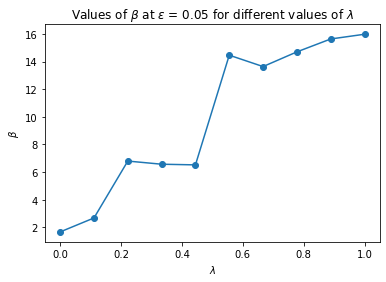

In [12]:
plt.plot(lambda_vec, initials_beta, '-o')
plt.title(r"Values of $\beta$ at $\epsilon$ = 0.05 for different values of $\lambda$")
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$\beta$')

### Generative model $G_2$

In [13]:
generator_class = G2
n_iterations = 1000
lambda_vec = np.linspace(0, 2, 10)

In [14]:
n_beta_iterations = 50
beta_vec_list = []
epsilon_vec = np.linspace(0.05, 0.95, 10)
lambda_arrays_list = []
for lambda_ in lambda_vec:
    print(f"Compute for lambda = {lambda_}")
    for i in range(n_beta_iterations):
        bo = BetaOptimizer(generator_class, lambda_, N, n_iterations, verbose=False)
        bo.run()
        beta_vec = compute_beta_vec(bo, epsilon_vec)
        beta_vec_list.append(beta_vec)
    lambda_arrays_list.append(np.array(beta_vec_list))

Compute for lambda = 0.0
Compute for lambda = 0.2222222222222222
Compute for lambda = 0.4444444444444444
Compute for lambda = 0.6666666666666666
Compute for lambda = 0.8888888888888888
Compute for lambda = 1.1111111111111112
Compute for lambda = 1.3333333333333333
Compute for lambda = 1.5555555555555554
Compute for lambda = 1.7777777777777777
Compute for lambda = 2.0


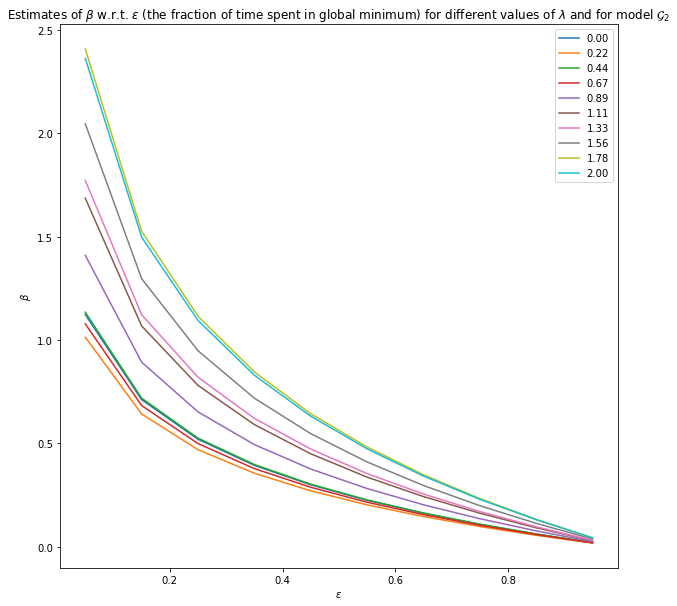

In [15]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title(r"Estimates of $\beta$ w.r.t. $\epsilon$ (the fraction of time spent in global minimum) "\
             r"for different values of $\lambda$ and for model $\mathcal{G}_2$")
for i, lambda_array in enumerate(lambda_arrays_list):
    ax.plot(epsilon_vec, lambda_array.mean(0), label=f"{lambda_vec[i]:.2f}")
ax.set_xlabel(r'$\epsilon$')
ax.set_ylabel(r'$\beta$')
plt.legend()

The values of $\beta$ corresponding to the smallest value of $\epsilon$, i.e. $\epsilon = 0.05$ are:

In [16]:
initials_beta = [lambda_array[:, 0].mean() for lambda_array in lambda_arrays_list]

Text(0, 0.5, '$\\beta$')

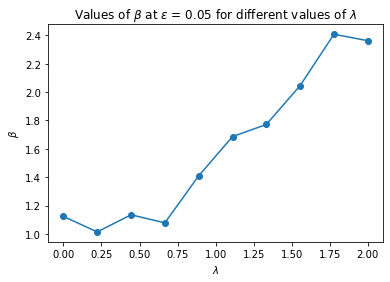

In [17]:
plt.plot(lambda_vec, initials_beta, '-o')
plt.title(r"Values of $\beta$ at $\epsilon$ = 0.05 for different values of $\lambda$")
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$\beta$')

## TODO:
Section Choosing $\beta$:
- Could add error bars to this plot
- Could add error areas on previous plots

Section MH sampler:
- Try different ways of decreasing $\beta$ with the number of iterations. E.g. linear decrease, 1 / x, 1 / sqrt(x), ...

## Jon's implementation of the MH sampler (just wanted to implement it as well the way I thought)

In [3]:
total_iterations_threshold = 100000

class MHSampler():
    def __init__(self, generator_class, lambda_, beta, N, n_iterations, verbose=False):
        self.N = N
        self.g = generator_class(N)
        self.lambda_ = lambda_
        self.beta = beta
        self.n_iterations = n_iterations
        self.distances_matrix = sp.spatial.distance_matrix(self.g.x, self.g.x)
        self.verbose = verbose

        # running variables
        # set initial set S with a random node
        self.S = {np.random.choice(range(N))}
        self.S_cardinality = len(self.S)
        self.population = self.compute_population(next(iter(self.S)))
        self.max_distance = 0.
        self.max_distance_new = 0.
        self.f = - self.population
        self.f_new = None
        
        # variables recording results
        self.population_vec = [self.population]
        self.f_vec = [self.f]
        self.max_distance_vec = [0.]
        self.S_cardinality_vec = [1]

    def __str__(self):
        s = f"generator: {self.g}\n" +\
            f"lambda: {self.lambda_}\n" +\
            f"initial beta: {self.beta}\n" +\
            f"N: {self.N}\n" +\
            f"initial state: {self.S}\n" +\
            f"n_iterations: {self.n_iterations}"
        return s

    def compute_population(self, candidate_id):
        return self.g.v[candidate_id]

    def compute_max_distance(self, candidate_id):
        if candidate_id in self.S:
            included_ids = list(self.S - {candidate_id})
        else:
            included_ids = list(self.S.union({candidate_id}))
        max_distance = self.distances_matrix[np.ix_(included_ids, included_ids)].max()
        return max_distance
            
    def compute_f(self, candidate_id):
        candidate_population = self.compute_population(candidate_id)
        if candidate_id in self.S:
            population_sum = self.population - candidate_population
        else:
            population_sum = self.population + candidate_population
        self.max_distance_new = self.compute_max_distance(candidate_id)
        circular_area = np.pi * (self.max_distance_new / 2)**2
        return self.lambda_ * self.N * circular_area - population_sum

    def choose_candidate(self):
        available_ids = list(range(self.N))
        # Discard the possibility of choosing the only node in S.
        # It avoids getting 0 nodes in S
        if self.S_cardinality == 1:
            available_ids = list(set(available_ids) - self.S)
        candidate_id = np.random.choice(available_ids)
        return candidate_id
    
    def update(self, candidate_id):
        candidate_population = self.compute_population(candidate_id)
        # If candidate node is in the current set S, 
        # changing its color means removing it from the set S.
        # The population would then have its population subtracted
        if candidate_id in self.S:
            self.population -= candidate_population
            self.S -= {candidate_id}
            self.S_cardinality -= 1
        # If candidate node is outside the set S, 
        # we include it and we then need to add its population
        else:
            self.population += candidate_population
            self.S = self.S.union({candidate_id})
            self.S_cardinality += 1
        self.S_cardinality_vec.append(self.S_cardinality)
        self.max_distance = self.max_distance_new
        self.max_distance_vec.append(self.max_distance.copy())
        self.population_vec.append(self.population.copy())
        self.f = self.f_new
        self.f_vec.append(self.f.copy())

    def run(self):
        total_counter = 0
        iterations_counter = 0
        while (iterations_counter < self.n_iterations) and (total_counter < total_iterations_threshold):
            candidate_id = self.choose_candidate()
            self.f_new = self.compute_f(candidate_id)
            acceptance_proba = np.exp(- self.beta * (self.f_new - self.f))
            u = st.uniform.rvs()
            if u < acceptance_proba:
                # we accept the move
                if self.verbose:
                    if candidate_id in self.S:
                        print(f"Node {candidate_id} removed.")
                    else:
                        print(f"Node {candidate_id} accepted.")
                self.update(candidate_id)
                iterations_counter += 1
            total_counter += 1

In [5]:
beta = 1.
lambda_ = 0
N = 100
n_iterations = 1000
generator_class = G1
ms = MHSampler(generator_class, lambda_, beta, N, n_iterations)

MH with lambda = 0.00
MH with lambda = 0.11
MH with lambda = 0.22
MH with lambda = 0.33
MH with lambda = 0.44
MH with lambda = 0.56
MH with lambda = 0.67
MH with lambda = 0.78
MH with lambda = 0.89
MH with lambda = 1.00


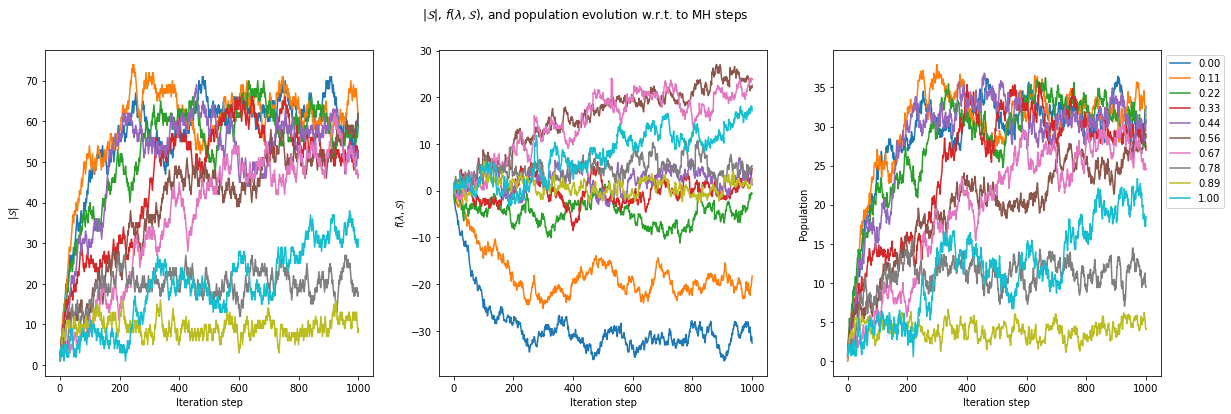

In [6]:
generator_class = G1
fig, axes = plt.subplots(1, 3, sharex=True, figsize=(20, 6))
# fig, axes = plt.subplots(1, 3, sharex=True, figsize=(14, 4))

fig.suptitle(r'$|\mathcal{S}|$, $f(\lambda, \mathcal{S})$, and population evolution w.r.t. to MH steps')

lambda_vec = np.linspace(0, 1, 10)
for lambda_ in lambda_vec:
    print(f"MH with lambda = {lambda_:.2f}")
    ms = MHSampler(generator_class, lambda_, beta, N, n_iterations)
    ms.run()
    axes[0].plot(ms.S_cardinality_vec, label=f"{ms.lambda_:.2f}")
    axes[0].set_xlabel('Iteration step')
    axes[0].set_ylabel(r'$|\mathcal{S}|$')

    axes[1].plot(ms.f_vec, label=f"{ms.lambda_:.2f}")
    axes[1].set_xlabel('Iteration step')
    axes[1].set_ylabel(r'$f(\lambda, \mathcal{S})$')

    axes[2].plot(ms.population_vec, label=f"{ms.lambda_:.2f}")
    axes[2].set_xlabel('Iteration step')
    axes[2].set_ylabel('Population')
axes[2].legend(bbox_to_anchor=(1, 1))

MH with lambda = 0.00
MH with lambda = 0.11
MH with lambda = 0.22
MH with lambda = 0.33
MH with lambda = 0.44
MH with lambda = 0.56
MH with lambda = 0.67
MH with lambda = 0.78
MH with lambda = 0.89
MH with lambda = 1.00


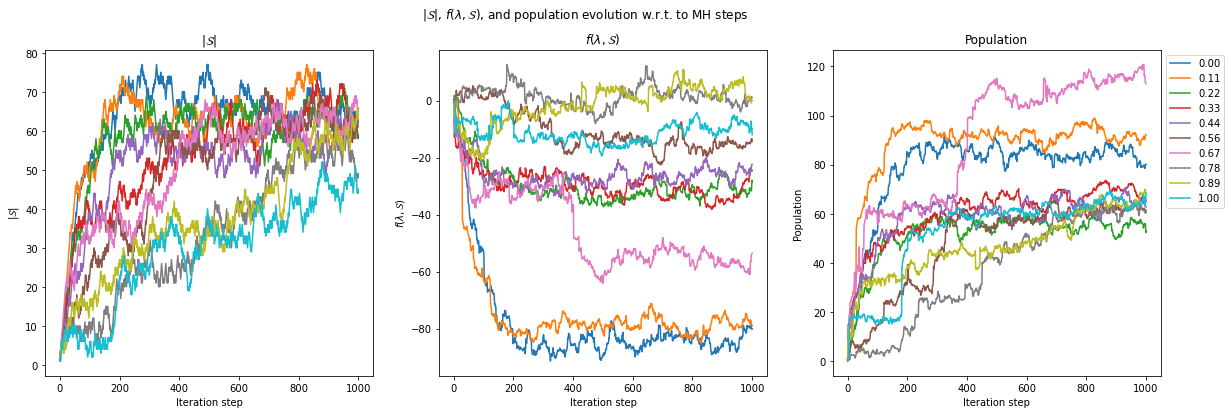

In [7]:
generator_class = G2
fig, axes = plt.subplots(1, 3, sharex=True, figsize=(20, 6))

fig.suptitle(r'$|\mathcal{S}|$, $f(\lambda, \mathcal{S})$, and population evolution w.r.t. to MH steps')

lambda_vec = np.linspace(0, 1, 10)
for lambda_ in lambda_vec:
    print(f"MH with lambda = {lambda_:.2f}")
    ms = MHSampler(generator_class, lambda_, beta, N, n_iterations)
    ms.run()
    axes[0].plot(ms.S_cardinality_vec, label=f"{ms.lambda_:.2f}")
    axes[0].set_title(r'$|\mathcal{S}|$')
    axes[0].set_xlabel('Iteration step')
    axes[0].set_ylabel(r'$|\mathcal{S}|$')

    axes[1].plot(ms.f_vec, label=f"{ms.lambda_:.2f}")
    axes[1].set_title(r'$f(\lambda, \mathcal{S})$')
    axes[1].set_xlabel('Iteration step')
    axes[1].set_ylabel(r'$f(\lambda, \mathcal{S})$')

    axes[2].plot(ms.population_vec, label=f"{ms.lambda_:.2f}")
    axes[2].set_title('Population')
    axes[2].set_xlabel('Iteration step')
    axes[2].set_ylabel('Population')
axes[2].legend(bbox_to_anchor=(1, 1))